<a href="https://colab.research.google.com/github/swastik2475/crop-disease-image-segmentation/blob/main/crop_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-acbyyzkp
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-acbyyzkp
  Resolved https://github.com/facebookresearch/detectron2.git to commit a1ce2f956a1d2212ad672e3c47d53405c2fe4312
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.8 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp312-cp312-linux_x86_64.whl size=6352512 sha256=2c16a961dfb520e70537701fca7fb7bca356340b4cd8b44814c539247ab6250a
  Stored in directory: /tmp/pip-ephem-wheel-cache-cf4u764g/wheels/d3/6e/bd/1969578f1456a6be2

In [ ]:
import torch, detectron2
print("Torch version:", torch.__version__)
print("Detectron2 version:", detectron2.__version__)

Torch version: 2.8.0+cu126
Detectron2 version: 0.6


In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog , DatasetCatalog

In [10]:
trains_json = "/content/crop_disease_data/train/_annotations.coco.json"
trains_img = "/content/crop_disease_data/train"

value_json = "/content/crop_disease_data/valid/_annotations.coco.json"
value_img = "/content/crop_disease_data/valid"

register_coco_instances("trains", {}, trains_json, trains_img)
register_coco_instances("value", {}, value_json, value_img)

[09/09 06:21:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/model_final.pth ...


roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Predicted Disease: brown_spot
Predicted Disease: brown_spot
Predicted Disease: brown_spot
Predicted Disease: brown_spot
Predicted Disease: brown_spot
Predicted Disease: brown_spot
Predicted Disease: brown_spot
Predicted Disease: brown_spot


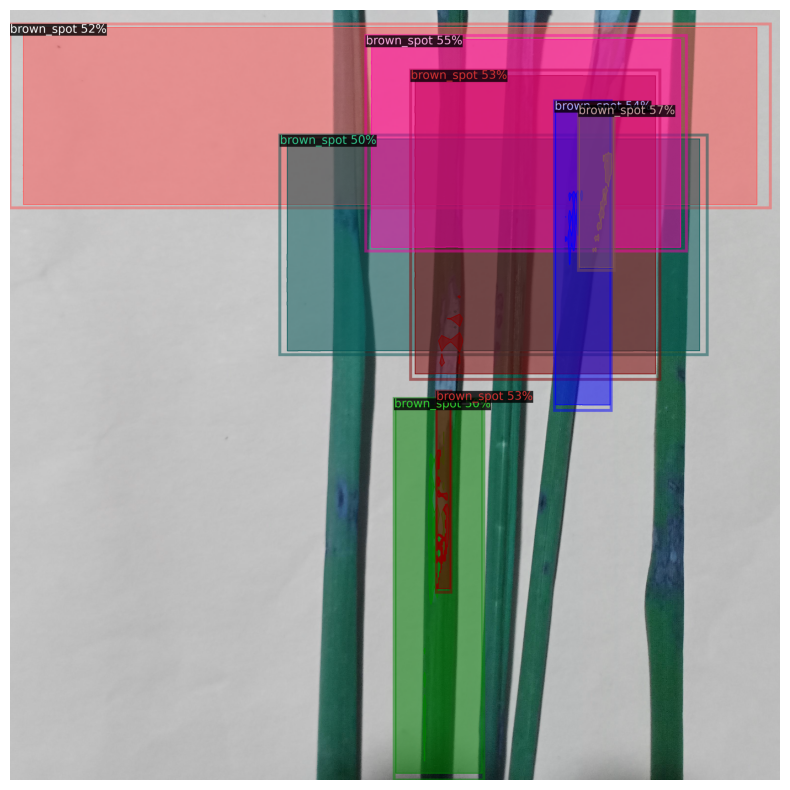

In [27]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import cv2
import matplotlib.pyplot as plt
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog


class_names = [
    "healthy",
    "leaf_blast",
    "brown_spot",
    "bacterial_blight",
    "tungro",
    "sheath_blight",
    "hispa"
]


cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(class_names)
cfg.MODEL.WEIGHTS = "/content/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = "cpu"


MetadataCatalog.get("crop_train").thing_classes = class_names


predictor = DefaultPredictor(cfg)


image_path = "/content/133_Rice_Leaf_Blast_train_jpg.rf.5b5ab9907e3f626ebe480285589f0829.jpg"
im = cv2.imread(image_path)
outputs = predictor(im)


pred_classes = outputs["instances"].pred_classes.cpu().numpy()
for cls_id in pred_classes:
    print("Predicted Disease:", class_names[cls_id])


v = Visualizer(
    im[:, :, ::-1],
    MetadataCatalog.get("crop_train"),
    scale=1.2,
    instance_mode=ColorMode.IMAGE
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

plt.figure(figsize=(10,10))
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()
